In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
from sklearn.naive_bayes import GaussianNB, ComplementNB
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc
import seaborn as sns; sns.set()
%matplotlib inline


# Define Helper Functions

In [304]:
def probability_to_label(probabilities, threshold=0.5):
    probabilities = list(probabilities)
    th = threshold
    predictions = [1 if i > th else 0 for i in probabilities]
    return predictions

In [317]:
def plot_cm(y_true, y_pred,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    import seaborn as sns; sns.set()
    from sklearn.metrics import confusion_matrix
    from sklearn.utils.multiclass import unique_labels
    sns.set_style('white')
    
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normarlize 
    classes = unique_labels(y_true, y_pred)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    pass

In [307]:
def plot_ROC(fpr, tpr, auc, title = 'ROC curve'):
    sns.set_style('whitegrid')

#     plt.figure(figsize=(8,6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=' (AUC = {:.3f})'.format(auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title)
    plt.legend(loc='best')
    plt.show()
    pass

In [330]:
def plot_PRC(precision, recall, ap, title= 'Precision-Recall Curve '):
    sns.set_style('whitegrid')

    plt.figure
#     plot(result5_1[0], result5_1[1],linestyle = "-", color = 'C0')#,label = 'AUC = %0.2f' % result5_1[3])
    plt.plot(recall, precision, lw=2, label='AP = %0.4f' % ap )
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="best")
#     plt.show()
    return 

In [331]:
def get_weights(y):
    weight = y.value_counts().values/y.value_counts().sum()
    index = y.value_counts().index
    y = y.values
    for i in range(index.size):
        y = np.where(y==index[i],weight[i],y)
    return y

## Load Data

In [332]:
data = pd.read_csv('data_pp_train_30d.csv')

In [328]:
test = pd.read_csv('data_pp_test_30d.csv')

# K-Fold Cross-Validation*

In [329]:
K = 5
skf = StratifiedKFold(n_splits=K)

# Naive Bayes

### Generate Gaussian Model and Fit Data

[0.8685344827586207, 0.8584360720751789, 0.8715406500560393, 0.8572290714716786, 0.7114406414346064]
[0.847986207874476, 0.8622459409328052, 0.8649481733111808, 0.864398548076717, 0.8577815026873206]


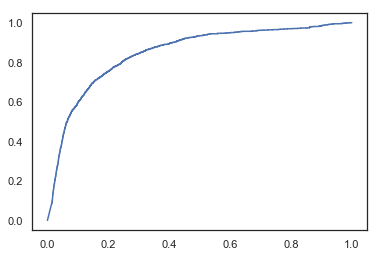

<Figure size 432x288 with 0 Axes>

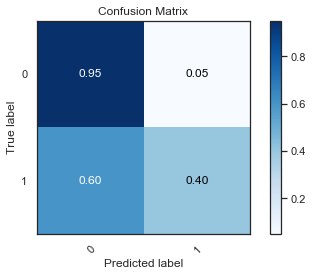

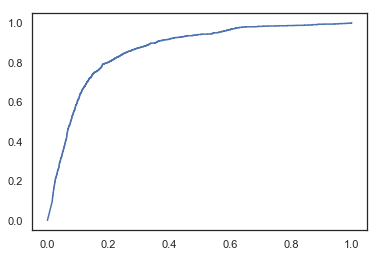

<Figure size 432x288 with 0 Axes>

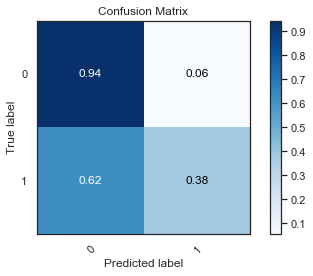

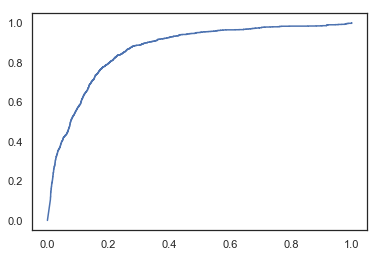

<Figure size 432x288 with 0 Axes>

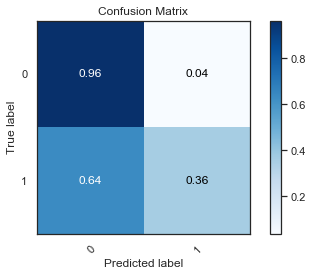

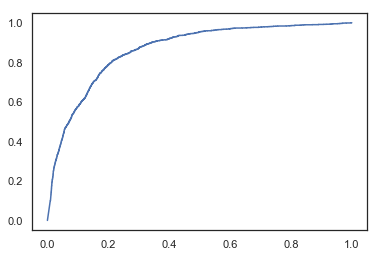

<Figure size 432x288 with 0 Axes>

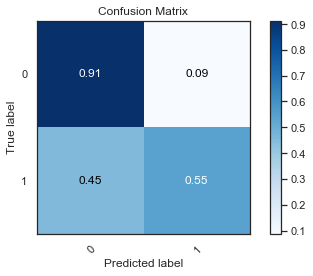

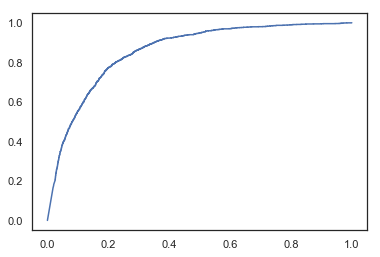

<Figure size 432x288 with 0 Axes>

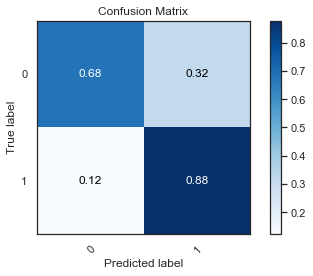

In [326]:
NBmodel30 = GaussianNB()
X = data.drop(['thirty_days','one_year'],axis=1)
y30 = data[['thirty_days']].astype(int)

Galpha = 1e-6
acc = [] 
auc = []
fpr_ls = []
tpr_ls = []
for t_in,v_in in skf.split(X,y30):
    Galpha = Galpha/10.0
    trainX = X.iloc[t_in].values
    trainy = y30.iloc[t_in]
    valX = X.iloc[v_in].values
    valy = y30.iloc[v_in]
    model = GaussianNB(var_smoothing=Galpha)
    model.fit(trainX,trainy.values.ravel(),get_weights(trainy.thirty_days))
    ypred = model.predict_proba(valX)
    ypred_label = probability_to_label(ypred[:,1],0.5)
    fpr, tpr, thresholds = roc_curve(valy,ypred[:,1])
    roc_auc = auc(fpr, tpr)
    auc30.append(roc_auc)
    acc30.append(model.score(valX,valy.values.ravel()))
    
print(acc30)
print(auc30)


0.8585555749455216
0.8594541961220418


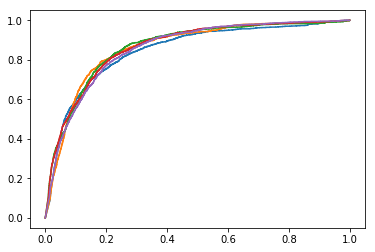

In [240]:
true_acc30 = [] 
true_auc30 = []
for t_in,v_in in skf.split(X,y30):
    Galpha = 1e-8
    trainX = X.iloc[t_in].values
    trainy = y30.iloc[t_in]
    valX = X.iloc[v_in].values
    valy = y30.iloc[v_in]
    model = GaussianNB(var_smoothing=Galpha)
    model.fit(trainX,trainy.values.ravel(),get_weights(trainy.thirty_days))
    out = model.predict_proba(valX)
    fpr, tpr, thresholds = roc_curve(valy,out[:,1])
    roc_auc = auc(fpr, tpr)
    auc30.append(roc_auc)
    acc30.append(model.score(valX,valy.values.ravel()))
    plt.plot(fpr,tpr)
print(np.mean(acc30))
print(np.mean(auc30))
plt.show()

### Generate Complement Model and Fit Data

In [94]:
NBCmodel30 = ComplementNB(alpha = 3)
NBCmodel1yr = ComplementNB(alpha= 3)
NBCmodel30.fit(X_train,y_30day_train)
NBCmodel1yr.fit(X_train,y_1yr_train)

ComplementNB(alpha=3, class_prior=None, fit_prior=True, norm=False)

### Test Performance

In [95]:
print(NBmodel30.score(X_test,y_30day_test))
print(NBmodel1yr.score(X_test,y_1yr_test))

0.756896551724138
0.7424137931034482


In [96]:
print(NBCmodel30.score(X_test,y_30day_test))
print(NBCmodel1yr.score(X_test,y_1yr_test))

0.7757758620689655
0.7311206896551724


In [111]:
NBmodel30.predict_proba(X_test)

array([[1.00000000e+00, 2.82296731e-16],
       [9.74888813e-01, 2.51111871e-02],
       [1.00000000e+00, 3.73147843e-20],
       ...,
       [1.00000000e+00, 1.01875828e-11],
       [9.99998681e-01, 1.31912373e-06],
       [4.68841937e-03, 9.95311581e-01]])

# kNN

### Generate Model and Fit Data

In [112]:
KNmodel30 = KNeighborsRegressor()
KNmodel1yr =  KNeighborsRegressor()
KNmodel1yr.fit(X_train,y_1yr_train)
KNmodel30.fit(X_train,y_30day_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

### Test Performance

In [89]:
output = KNmodel30.predict_proba(X_test)

In [103]:
pd.DataFrame(output)[1].value_counts()

0.0    8828
0.2    1175
1.0     634
0.4     429
0.6     322
0.8     212
Name: 1, dtype: int64

In [78]:
KNmodel30.score(X_test,y_30day_test)

0.9216379310344828

In [79]:
KNmodel1yr.score(X_test,y_1yr_test)

0.8496551724137931

# XGboost

In [277]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [278]:
xg = XGBClassifier(verbosity=2)

In [279]:
np.log(0.6)

-0.5108256237659907

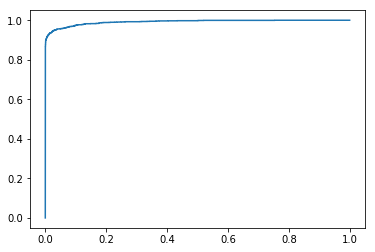

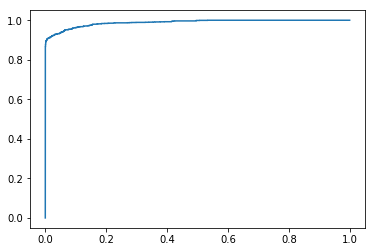

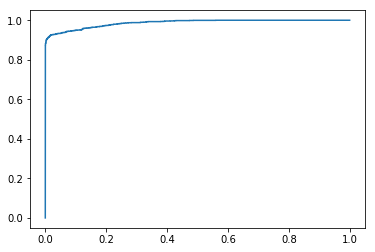

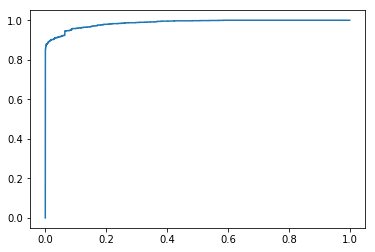

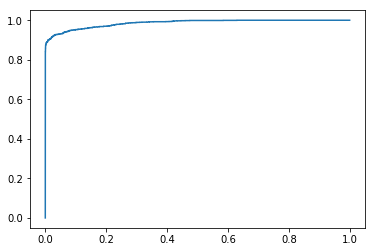

In [286]:
xgacc = []
xgauc = []
for t_in,v_in in skf.split(X,y30):
    trainX = X.iloc[t_in].values
    trainy = y30.iloc[t_in]
    valX = X.iloc[v_in].values
    valy = y30.iloc[v_in]
    xg.fit(trainX,trainy.values.ravel(),get_weights(trainy.thirty_days))
    xgout = xg.predict_proba(valX)
#     xgout[xgout>0.5] = 1
#     xgout[xgout<=0.5] = 0
#     accuracy = accuracy_score(valy.values.ravel(), xgout)
#     print(accuracy)
    fpr, tpr, thresholds = roc_curve(valy.values.ravel(),xgout[:,1])
    roc_auc = auc(fpr, tpr)
    xgauc.append(roc_auc)
#     xgacc.append(accuracy_score(valy.values.ravel(), xgout))
    plt.figure()
    plt.plot(fpr,tpr)
    plt.show()

In [288]:
featureimp = xg.feature_importances_

FileNotFoundError: [Errno 2] No such file or directory: 'figures/Feature_importance.png'

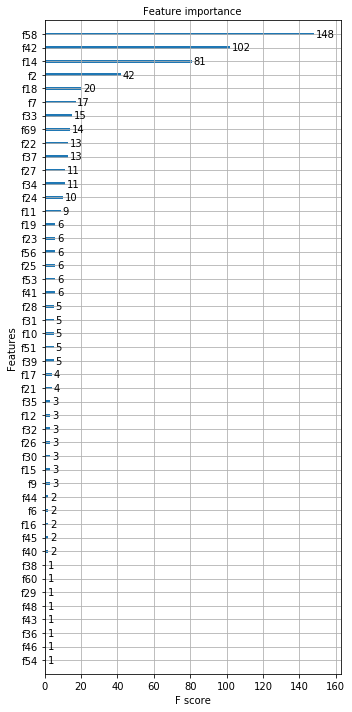

In [289]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=(figsize))
    plot_importance(booster=booster, ax=ax, **kwargs)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label,] +
ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)
    plt.tight_layout()
    fig.savefig('figures/Feature_importance.png')

my_plot_importance(xg, (5,10))

In [292]:
data.columns

Index(['first_careunit', 'last_careunit', 'age', 'age_category', 'gender',
       'marital_status', 'insurance', 'urea_n_min', 'urea_n_max',
       'urea_n_mean',
       ...
       'spo2_max_mv', 'spo2_mean_mv', 'vent_mv', 'rrt_mv', 'urineoutput_mv',
       'oasis_mv', 'lods_mv', 'sirs_mv', 'thirty_days', 'one_year'],
      dtype='object', length=112)

In [298]:
x = zip(data.drop(['thirty_days','one_year'],axis=1).columns,featureimp)

In [300]:
print(x)